# LLM Classification Fine-tuning

This notebook walks through the process of fine-tuning a large language model (LLM) for a text classification task. The goal is to prepare the data, fine-tune a pre-trained model, and evaluate its performance for submission to the Kaggle competition.

## Step 1: Load and Inspect the Data
Will load the training and test datasets provided in the competition. By inspecting the data, we aim to understand the structure, identify the target and feature columns, and check for missing or invalid values.

- Input: CSV files containing the training and test data.
- Output: An overview of the data structure, including a preview of the rows and columns.

In [1]:
import os
!pip install kaggle
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c llm-classification-finetuning
!unzip -q llm-classification-finetuning.zip -d data

Saving kaggle.json to kaggle.json
 86% 49.0M/57.0M [00:01<00:00, 44.1MB/s]
100% 57.0M/57.0M [00:01<00:00, 47.3MB/s]


In [11]:
import os
!pip install kaggle transformers

In [27]:
# Import necessary libraries
import pandas as pd

# Load train and test datasets
train_df = pd.read_csv('data/train.csv')  # Replace 'train.csv' with the actual filename
test_df = pd.read_csv('data/test.csv')

# Display first few rows of the training data for inspection
print(train_df.head())

# Display first few rows of the test data
print(test_df.head())

       id             model_a              model_b  \
0   30192  gpt-4-1106-preview           gpt-4-0613   
1   53567           koala-13b           gpt-4-0613   
2   65089  gpt-3.5-turbo-0613       mistral-medium   
3   96401    llama-2-13b-chat  mistral-7b-instruct   
4  198779           koala-13b   gpt-3.5-turbo-0314   

                                              prompt  \
0  ["Is it morally right to try to have a certain...   
1  ["What is the difference between marriage lice...   
2  ["explain function calling. how would you call...   
3  ["How can I create a test set for a very rare ...   
4  ["What is the best way to travel from Tel-Aviv...   

                                          response_a  \
0  ["The question of whether it is morally right ...   
1  ["A marriage license is a legal document that ...   
2  ["Function calling is the process of invoking ...   
3  ["Creating a test set for a very rare category...   
4  ["The best way to travel from Tel Aviv to Jeru...   

 

In [28]:
train_df.describe()

,id,winner_model_a,winner_model_b,winner_tie
count,5.747700e+04,57477.000000,57477.000000,57477.000000
mean,2.142564e+09,0.349079,0.341911,0.309011
std,1.238327e+09,0.476683,0.474354,0.462090
min,3.019200e+04,0.000000,0.000000,0.000000
25%,1.071821e+09,0.000000,0.000000,0.000000
50%,2.133658e+09,0.000000,0.000000,0.000000
75%,3.211645e+09,1.000000,1.000000,1.000000
max,4.294947e+09,1.000000,1.000000,1.000000


In [29]:
test_df.describe()

,id
count,3.000000e+00
mean,5.271180e+05
std,6.132999e+05
min,1.360600e+05
25%,1.736965e+05
50%,2.113330e+05
75%,7.226470e+05
max,1.233961e+06


In [30]:
# take only 10000 train data and 2000 test data
train_df = train_df.head(10000)
test_df = test_df.head(2000)

In [44]:
# Check for missing values
missing_values = train_df.isnull().sum()
print(missing_values)


id                 0
model_a            0
model_b            0
prompt             0
response_a         0
response_b         0
winner_model_a     0
winner_model_b     0
winner_tie         0
labels             0
prompt_response    0
dtype: int64


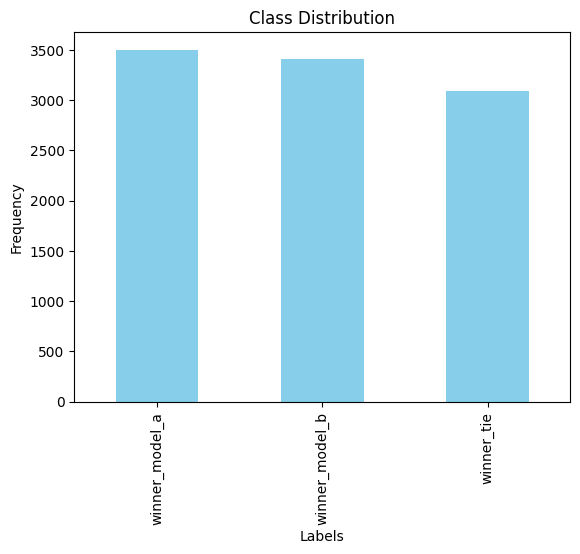

In [48]:
#@title Show class distribution
import matplotlib.pyplot as plt

# Combine target columns into a single label
train_df['label'] = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].idxmax(axis=1)

# Plot class distribution
train_df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()


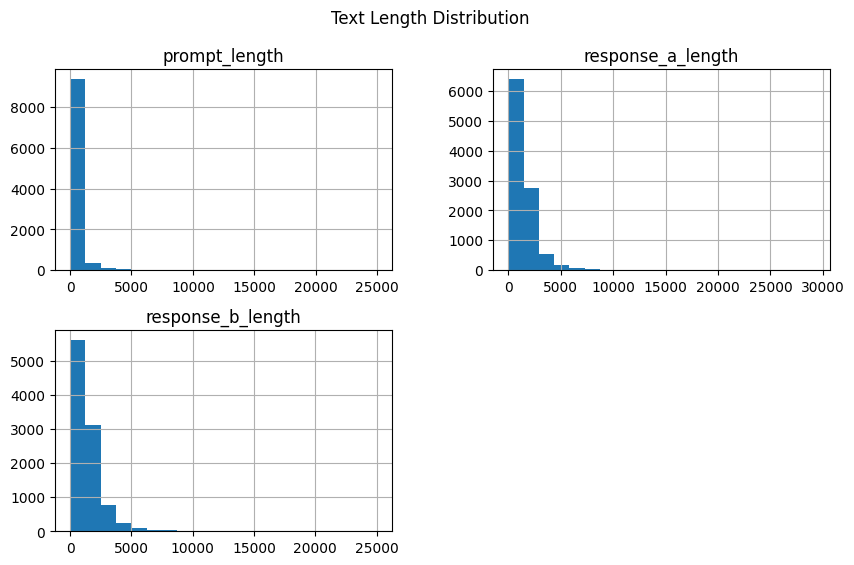

In [49]:
# Compute text lengths
train_df['prompt_length'] = train_df['prompt'].apply(len)
train_df['response_a_length'] = train_df['response_a'].apply(len)
train_df['response_b_length'] = train_df['response_b'].apply(len)

# Plot text lengths
train_df[['prompt_length', 'response_a_length', 'response_b_length']].hist(bins=20, figsize=(10, 6))
plt.suptitle('Text Length Distribution')
plt.show()


## Step 2: Data Preprocessing
Before feeding the data to the model, we need to tokenize the text using a pre-trained tokenizer. Tokenization converts the raw text into numerical input IDs and attention masks that the model understands.

Key steps include:

- Truncating or padding the text to a fixed length.
- Converting text into token IDs.
- Adding attention masks to handle padding.

We use the AutoTokenizer from the Hugging Face transformers library for this.



In [31]:
print(train_df.columns)
print(test_df.columns)

Index(['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b',
       'winner_model_a', 'winner_model_b', 'winner_tie'],
      dtype='object')
Index(['id', 'prompt', 'response_a', 'response_b'], dtype='object')


In [32]:
# Map the three columns into a single 'labels' column
def combine_winner_columns(row):
    if row['winner_model_a'] == 1:
        return 0  # Model A wins
    elif row['winner_model_b'] == 1:
        return 1  # Model B wins
    elif row['winner_tie'] == 1:
        return 2  # Tie
    else:
        return 0  # Invalid or undefined case

# Apply the function to create a new 'label' column
train_df['labels'] = train_df.apply(combine_winner_columns, axis=1)


In [33]:
# combine prompt and responses
def combine_prompt_response(row):
  return row['prompt'] + " [SEP] " + row['response_a'] + " [SEP] " + row['response_b']

# Apply the function to create a new 'prompt_response' column
train_df['prompt_response'] = train_df.apply(combine_prompt_response, axis=1)

In [53]:
# Do the same for test_df as well
# Apply the function to create a new 'prompt_response' column
test_df['prompt_response'] = test_df.apply(combine_prompt_response, axis=1)

In [25]:
train_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,labels,prompt_response
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,1,"[""Is it morally right to try to have a certain..."
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,2,"[""What is the difference between marriage lice..."
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,3,"[""explain function calling. how would you call..."
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,1,"[""How can I create a test set for a very rare ..."
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,2,"[""What is the best way to travel from Tel-Aviv..."


In [34]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# Load the tokenizer
# Use 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Split training data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["prompt_response"],  # Use the relevant text column
    train_df["labels"],
    test_size=0.2,  # 20% for validation
    random_state=42
)

# Tokenize train and validation datasets
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")

In [54]:
from transformers import AutoTokenizer

# Load the tokenizer (use the same tokenizer as training)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Preprocess the test data
def preprocess(data, tokenizer, max_length=128):
    return tokenizer(
        data['prompt_response'].tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize test dataset
test_encodings = preprocess(test_df, tokenizer)

## Step 3: Dataset Preparation
To train the model, we need to structure the tokenized data into a format compatible with PyTorch. This involves:

- Creating a custom Dataset class to handle the tokenized inputs and their corresponding labels.
- Wrapping the dataset into PyTorch’s DataLoader for efficient batch processing during training.


In [35]:
!pip install datasets
# Import the necessary class or module
from datasets import Dataset

# Create Dataset objects
train_dataset = Dataset.from_dict(train_encodings)
train_dataset = train_dataset.add_column("labels", train_labels.values)

eval_dataset = Dataset.from_dict(val_encodings)
eval_dataset = eval_dataset.add_column("labels", val_labels.values)

## Step 4: Model Fine-tuning
Here, we load a pre-trained transformer model with a classification head. The model is fine-tuned on the training data to adapt it to the specific task.

Steps include:

- Loading a pre-trained model such as BERT or RoBERTa.
- Specifying the number of output labels based on the target variable.
- Setting up the training arguments such as learning rate, batch size, and number of epochs.
- Using the Hugging Face Trainer class to simplify training and evaluation.


In [39]:
from transformers import AutoModelForSequenceClassification

# Find unique labels from both training and validation data
all_labels = set(train_labels.values).union(set(val_labels.values))
num_labels = len(all_labels)

# Load a pre-trained model with a classification head
# Set the number of unique classes based on all the labels
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
num_labels

3

In [42]:
from transformers import Trainer, TrainingArguments

os.environ["WANDB_MODE"] = "disabled"

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="no",
    learning_rate=8e-3,
    per_device_train_batch_size=10,
    gradient_accumulation_steps=2,
    logging_steps=1000,
    num_train_epochs=1,
    save_steps=10_000,
    fp16=True,  # Enable mixed precision
    save_total_limit=2,
)

# Define a Trainer instance for training the model
# Update Trainer with the evaluation dataset
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Step,Training Loss


Step,Training Loss


TrainOutput(global_step=400, training_loss=1.1868423461914062, metrics={'train_runtime': 6449.2684, 'train_samples_per_second': 1.24, 'train_steps_per_second': 0.062, 'total_flos': 264939522048000.0, 'train_loss': 1.1868423461914062, 'epoch': 1.0})

## Step 5: Generate Predictions
After training the model, we use it to predict the labels for the test dataset. The predictions are stored in a submission.csv file, formatted according to the competition guidelines.

Steps include:

- Running inference on the test dataset.
- Extracting the predicted labels.
- Creating and saving the submission file.


In [55]:
#@title Create the test_dataset
from torch.utils.data import Dataset

# Define the custom Dataset class
class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item

# Create a TextDataset object for the test data
test_dataset = TextDataset(test_encodings)

In [57]:
!pip install torch
import torch
# Make predictions
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Save predictions to a DataFrame
submission = pd.DataFrame({"id": test_df["id"], "label": predicted_labels})
submission.to_csv("submission.csv", index=False)

\## Step 6: Submit to Kaggle
Finally, the generated submission.csv file can be uploaded to Kaggle for evaluation. Use the Kaggle CLI or the competition interface for submission.

Example command:

```bash
Copy code
kaggle competitions submit -c llm-classification-finetuning -f submission.csv -m "First submission"
```

In [ ]:

# Example command for submission:
# kaggle competitions submit -c llm-classification-finetuning -f submission.csv -m "First submission"
